# Extended Model: Minimal stochastic tunnel model

In [9]:
import pandas as pd

DATA_PATH = "dataset/data.xlsx"

xls = pd.ExcelFile(DATA_PATH)
print(xls.sheet_names)

['raw data', 'Figure 3B']


In [10]:
import pandas as pd
import numpy as np

DATA_PATH = "dataset/data.xlsx"

raw = pd.read_excel(DATA_PATH, sheet_name="raw data")
fig3b = pd.read_excel(DATA_PATH, sheet_name="Figure 3B")

raw.head()

,ID,Time,Complexity,Tunnel width,Tunnel width of shortcuts,Creating Shortcuts,How many shortcuts,Shortest travel distance,Travel distance of short cuts (shortest),Travel distance,Number of branching tunnels
0,Colony 1_1,0,Straight,3.000000,NaN,N,0,151.245692,0.0,151.245692,0
1,Colony 1_1,6,Straight,3.254627,NaN,N,0,153.396511,0.0,153.396511,2
2,Colony 1_1,12,Straight,3.403531,NaN,N,0,153.903212,0.0,153.903212,3
3,Colony 1_1,18,Straight,3.743884,NaN,N,0,153.018719,0.0,153.018719,3
4,Colony 1_1,24,Straight,4.956392,NaN,N,0,153.387364,0.0,153.387364,3


In [11]:
# =========================
# Data cleaning & formatting
# =========================

# Strip column names
raw.columns = raw.columns.str.strip()

# Y/N -> binary
raw["Creating Shortcuts"] = (
    raw["Creating Shortcuts"]
    .astype(str)
    .str.strip()
    .map({"Y": 1, "N": 0})
)

# Convert numeric columns
numeric_cols = [
    "Time",
    "Tunnel width",
    "Tunnel width of shortcuts",
    "How many shortcuts",
    "Shortest travel distance",
    "Travel distance of short cuts (shortest)",
    "Travel distance",
    "Number of branching tunnels",
]

for col in numeric_cols:
    raw[col] = pd.to_numeric(raw[col], errors="coerce")

# Quick check
raw.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75 entries, 0 to 74
Data columns (total 11 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   ID                                        75 non-null     object 
 1   Time                                      75 non-null     int64  
 2   Complexity                                75 non-null     object 
 3   Tunnel width                              75 non-null     float64
 4   Tunnel width of shortcuts                 29 non-null     float64
 5   Creating Shortcuts                        75 non-null     int64  
 6   How many shortcuts                        75 non-null     int64  
 7   Shortest travel distance                  75 non-null     float64
 8   Travel distance of short cuts (shortest)  75 non-null     float64
 9   Travel distance                           75 non-null     float64
 10  Number of branching tunnels             

In [12]:
# =========================
# Foraging efficiency metric
# =========================

L = raw["Travel distance"]
Ls = raw["Travel distance of short cuts (shortest)"]

raw["efficiency_gain"] = (L - Ls) / L

# If no shortcut, efficiency gain = 0
raw.loc[raw["Creating Shortcuts"] == 0, "efficiency_gain"] = 0

raw[["Travel distance", "Travel distance of short cuts (shortest)", "efficiency_gain"]].head()


,Travel distance,Travel distance of short cuts (shortest),efficiency_gain
0,151.245692,0.0,0.0
1,153.396511,0.0,0.0
2,153.903212,0.0,0.0
3,153.018719,0.0,0.0
4,153.387364,0.0,0.0


/var/folders/4p/5xs8l8p12tv7c0q4650ht5jw0000gn/T/ipykernel_98906/1264851291.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=groups)


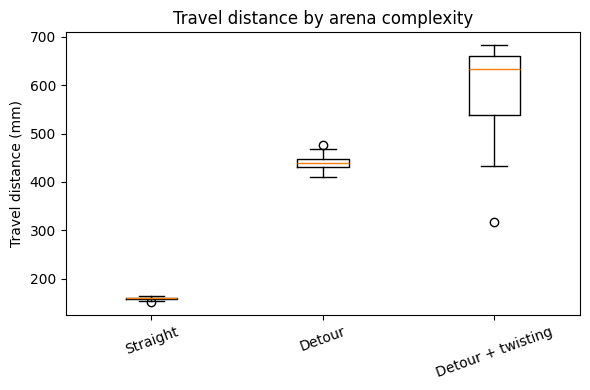

In [13]:
# Figure 1 Box plot
import matplotlib.pyplot as plt

groups = raw["Complexity"].unique()
data = [
    raw.loc[raw["Complexity"] == g, "Travel distance"].dropna()
    for g in groups
]

plt.figure(figsize=(6,4))
plt.boxplot(data, labels=groups)
plt.ylabel("Travel distance (mm)")
plt.title("Travel distance by arena complexity")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()


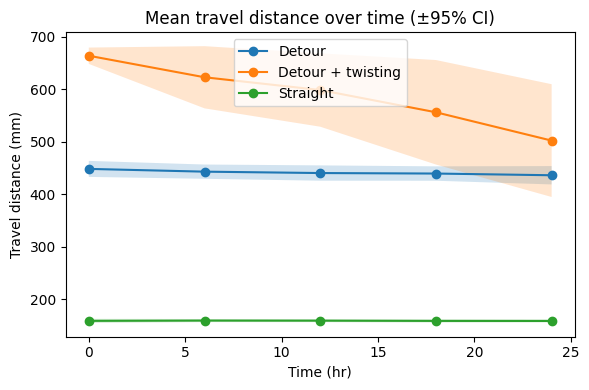

,Complexity,Time,mean,ci95
0,Detour,0,448.248999,15.257386
1,Detour,6,442.980821,13.596574
2,Detour,12,440.330124,14.615294
3,Detour,18,439.379618,13.727717
4,Detour,24,436.118532,17.501614


In [14]:
import numpy as np
import matplotlib.pyplot as plt

def ci95(x):
    x = x.dropna().values
    n = len(x)
    if n <= 1:
        return 0.0
    se = np.std(x, ddof=1) / np.sqrt(n)
    return 1.96 * se

# 1) groupby + agg，
stats = (
    raw.groupby(["Complexity", "Time"])["Travel distance"]
       .agg(mean="mean", ci95=ci95)
       .reset_index()
)

# 2) plot
plt.figure(figsize=(6,4))
for comp in stats["Complexity"].unique():
    sub = stats[stats["Complexity"] == comp].sort_values("Time")
    plt.plot(sub["Time"], sub["mean"], marker="o", label=comp)
    plt.fill_between(
        sub["Time"],
        sub["mean"] - sub["ci95"],
        sub["mean"] + sub["ci95"],
        alpha=0.2
    )

plt.xlabel("Time (hr)")
plt.ylabel("Travel distance (mm)")
plt.title("Mean travel distance over time (±95% CI)")
plt.legend()
plt.tight_layout()
plt.show()

# optional debug
stats.head()


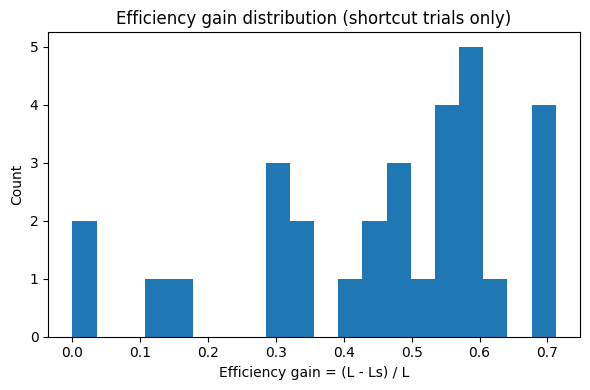

n(shortcut trials) = 30
mean gain = 0.45803902647936395
median gain = 0.50463579442322


In [15]:
# Figure 3A：Efficiency gain distribution (Histogram)
import matplotlib.pyplot as plt
import numpy as np

# only "shortcut" trials
gain_shortcut = raw.loc[raw["Creating Shortcuts"] == 1, "efficiency_gain"].dropna()

plt.figure(figsize=(6,4))
plt.hist(gain_shortcut.values, bins=20)
plt.xlabel("Efficiency gain = (L - Ls) / L")
plt.ylabel("Count")
plt.title("Efficiency gain distribution (shortcut trials only)")
plt.tight_layout()
plt.show()

print("n(shortcut trials) =", len(gain_shortcut))
print("mean gain =", np.mean(gain_shortcut))
print("median gain =", np.median(gain_shortcut))


/var/folders/4p/5xs8l8p12tv7c0q4650ht5jw0000gn/T/ipykernel_98906/3170493464.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=complexities)


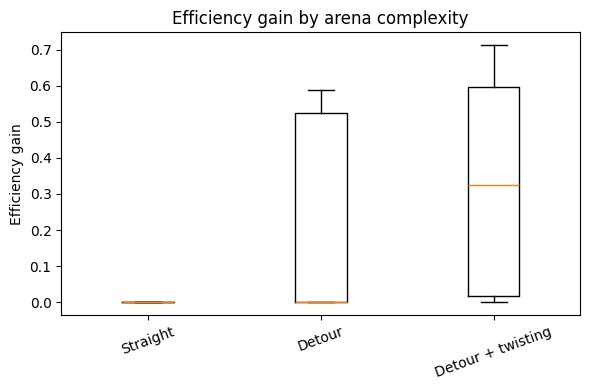

In [16]:
# Figure 3B：Efficiency gain vs Complexity（Boxplot）
complexities = ["Straight", "Detour", "Detour + twisting"]

data = [
    raw.loc[raw["Complexity"] == c, "efficiency_gain"].dropna().values
    for c in complexities
]

plt.figure(figsize=(6,4))
plt.boxplot(data, labels=complexities)
plt.ylabel("Efficiency gain")
plt.title("Efficiency gain by arena complexity")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()


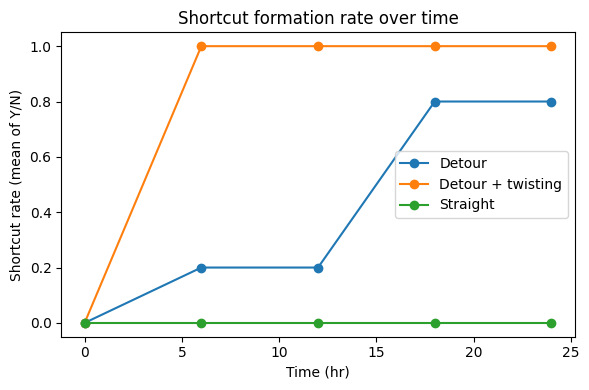

In [17]:
# Figure 3C Shortcut rate vs Time
rate = (
    raw.groupby(["Complexity", "Time"])["Creating Shortcuts"]
       .mean()
       .reset_index(name="shortcut_rate")
)

plt.figure(figsize=(6,4))
for comp in rate["Complexity"].unique():
    sub = rate[rate["Complexity"] == comp].sort_values("Time")
    plt.plot(sub["Time"], sub["shortcut_rate"], marker="o", label=comp)

plt.xlabel("Time (hr)")
plt.ylabel("Shortcut rate (mean of Y/N)")
plt.title("Shortcut formation rate over time")
plt.ylim(-0.05, 1.05)
plt.legend()
plt.tight_layout()
plt.show()


# Model Visualisation

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from collections import deque

In [19]:
# a minimal BFS implementation for shortest path in grid
def bfs_shortest_path_length(passable: np.ndarray, start, goal):
    """
    passable: 2D bool array, True means walkable
    start/goal: (r, c)
    Returns shortest path length in grid steps, or np.inf if unreachable
    """
    R, C = passable.shape
    sr, sc = start
    gr, gc = goal
    if not passable[sr, sc] or not passable[gr, gc]:
        return np.inf

    q = deque([(sr, sc, 0)])
    visited = np.zeros_like(passable, dtype=bool)
    visited[sr, sc] = True

    # 4-neighborhood
    for_r = [1, -1, 0, 0]
    for_c = [0, 0, 1, -1]

    while q:
        r, c, d = q.popleft()
        if (r, c) == (gr, gc):
            return d
        for dr, dc in zip(for_r, for_c):
            nr, nc = r + dr, c + dc
            if 0 <= nr < R and 0 <= nc < C and (not visited[nr, nc]) and passable[nr, nc]:
                visited[nr, nc] = True
                q.append((nr, nc, d + 1))
    return np.inf


def simulate_termite_model(
    arena="Straight",
    N=30,
    steps=400,
    grid_size=80,
    v=1.0,
    sigma=0.35,
    p_branch=0.02,
    p_shortcut=0.003,
    tunnel_threshold=6,
    seed=0,
):
    rng = np.random.default_rng(seed)

    # Grid: coordinates as (row, col)
    R = C = grid_size
    entrance = (R//2, 5)
    food = (R//2, C-6)

    # Obstacles define "complexity"
    obstacle = np.zeros((R, C), dtype=bool)

    if arena in ["Detour", "Detour + twisting"]:
        # A vertical wall forcing detour
        wall_c = C//2
        obstacle[:, wall_c] = True
        gap_r = R//2  # central gap
        obstacle[gap_r-6:gap_r+6, wall_c] = False

    if arena == "Detour + twisting":
        # Add a zigzag corridor obstacles to induce twisting
        for k in range(10, C-10, 10):
            rr = (R//2 - 15) if (k//10) % 2 == 0 else (R//2 + 15)
            obstacle[rr-2:rr+2, k:k+8] = True

    # Ensure entrance & food are free
    obstacle[entrance] = False
    obstacle[food] = False

    # Agent states
    pos = np.tile(np.array(entrance, dtype=float), (N, 1))
    theta = rng.uniform(0, 2*np.pi, size=N)

    # Tunnel as visitation count map
    visits = np.zeros((R, C), dtype=int)

    # Store metrics
    L_series = []
    shortcut_flag_series = []

    # For visualization, store a few trajectories
    traj_store = [[] for _ in range(min(8, N))]

    for t in range(steps):
        shortcut_happened = 0

        for i in range(N):
            # Heading noise (Gaussian)
            theta[i] += rng.normal(0.0, sigma)

            # Proposed move in continuous space
            dr = v * np.sin(theta[i])
            dc = v * np.cos(theta[i])
            new_r = pos[i, 0] + dr
            new_c = pos[i, 1] + dc

            # Project to grid and clip boundaries
            rr = int(np.clip(round(new_r), 0, R-1))
            cc = int(np.clip(round(new_c), 0, C-1))

            # If hit obstacle, reflect heading (simple)
            if obstacle[rr, cc]:
                theta[i] += np.pi/2 + rng.normal(0.0, sigma*0.5)
                rr, cc = int(pos[i, 0]), int(pos[i, 1])
            else:
                pos[i, 0], pos[i, 1] = rr, cc

            # Update visits
            visits[rr, cc] += 1

            # Store a few trajectories
            if i < len(traj_store):
                traj_store[i].append((rr, cc))

            # Branching event: locally "widen" by adding visits nearby
            if rng.random() < p_branch:
                for _ in range(3):
                    nr = int(np.clip(rr + rng.integers(-1, 2), 0, R-1))
                    nc = int(np.clip(cc + rng.integers(-1, 2), 0, C-1))
                    if not obstacle[nr, nc]:
                        visits[nr, nc] += 1

            # Shortcut event: carve a short connection towards food by boosting a thin line
            if rng.random() < p_shortcut and (abs(cc - C//2) < 8):
                # draw a small segment towards food
                r0, c0 = rr, cc
                r1, c1 = food
                K = 15  # length of carved segment
                for k in range(1, K+1):
                    rr2 = int(np.clip(round(r0 + (r1 - r0) * k / K), 0, R-1))
                    cc2 = int(np.clip(round(c0 + (c1 - c0) * k / K), 0, C-1))
                    if not obstacle[rr2, cc2]:
                        visits[rr2, cc2] += 2
                shortcut_happened = 1

        # Define tunnel cells by threshold
        tunnel = (visits >= tunnel_threshold) & (~obstacle)
        tunnel[entrance] = True
        tunnel[food] = True

        # Compute travel distance on tunnel network (grid BFS)
        L = bfs_shortest_path_length(tunnel, entrance, food)
        L_series.append(L)
        shortcut_flag_series.append(shortcut_happened)

    result = {
        "visits": visits,
        "obstacle": obstacle,
        "entrance": entrance,
        "food": food,
        "L_series": np.array(L_series, dtype=float),
        "shortcut_flag": np.array(shortcut_flag_series, dtype=int),
        "traj_store": traj_store,
        "arena": arena,
        "params": dict(N=N, steps=steps, grid_size=grid_size, v=v, sigma=sigma,
                       p_branch=p_branch, p_shortcut=p_shortcut, tunnel_threshold=tunnel_threshold, seed=seed),
    }
    return result


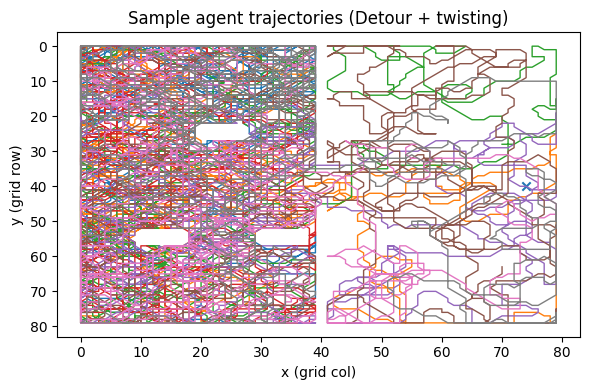

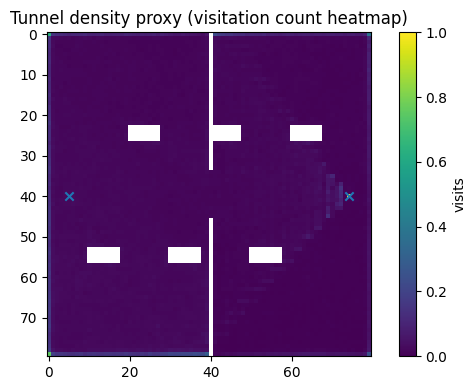

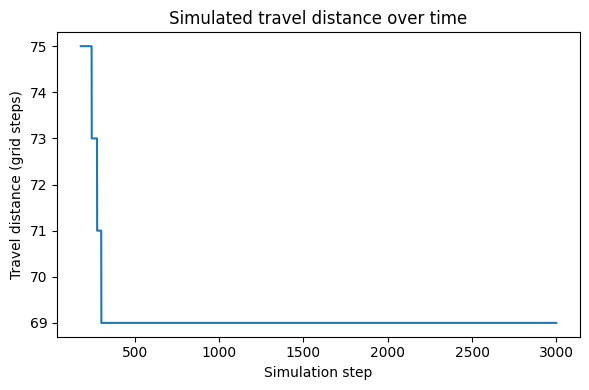

Last finite travel distance: 69 grid steps


In [20]:
# run the simulation with chosen parameters
# res = simulate_termite_model(
#     arena="Detour + twisting",
#     N=40,
#     steps=500,
#     sigma=0.45,
#     p_branch=0.03,
#     p_shortcut=0.005,
#     tunnel_threshold=7,
#     seed=3
# )
res = simulate_termite_model(
    arena="Detour + twisting",
    N=120,
    steps=3000,
    sigma=0.55,
    p_branch=0.08,
    p_shortcut=0.03,
    tunnel_threshold=2,  
    seed=3
)

visits = res["visits"]
obstacle = res["obstacle"]
entrance = res["entrance"]
food = res["food"]
L_series = res["L_series"]
traj_store = res["traj_store"]

# -------------------------
# Fig M1: a few agent trajectories
# -------------------------
plt.figure(figsize=(6,4))
for tr in traj_store:
    if len(tr) > 2:
        rr = [p[0] for p in tr]
        cc = [p[1] for p in tr]
        plt.plot(cc, rr, linewidth=1)
plt.scatter([entrance[1], food[1]], [entrance[0], food[0]], marker="x")
plt.gca().invert_yaxis()
plt.title(f"Sample agent trajectories ({res['arena']})")
plt.xlabel("x (grid col)")
plt.ylabel("y (grid row)")
plt.tight_layout()
plt.show()

# -------------------------
# Fig M2: tunnel density (visitation heatmap)
# -------------------------
plt.figure(figsize=(6,4))
vis_plot = visits.copy().astype(float)
vis_plot[obstacle] = np.nan
plt.imshow(vis_plot, origin="upper")
plt.scatter([entrance[1], food[1]], [entrance[0], food[0]], marker="x")
plt.title("Tunnel density proxy (visitation count heatmap)")
plt.colorbar(label="visits")
plt.tight_layout()
plt.show()

# -------------------------
# Fig M3: travel distance over time (robust plotting)
# -------------------------
# Convert inf to NaN so matplotlib can plot valid segments
L_plot = L_series.astype(float).copy()
L_plot[~np.isfinite(L_plot)] = np.nan

valid_ratio = np.mean(np.isfinite(L_series))
if valid_ratio < 0.2:
    print(
        f"[Warning] Only {valid_ratio*100:.1f}% of time steps have a finite path.\n"
        "This usually means the tunnel network rarely connects entrance to food.\n"
        "Try one of these:\n"
        "  - decrease tunnel_threshold (e.g., 7 -> 4)\n"
        "  - increase steps (e.g., 500 -> 1500)\n"
        "  - increase p_branch / p_shortcut slightly\n"
    )

plt.figure(figsize=(6,4))
plt.plot(np.arange(len(L_plot)), L_plot)
plt.title("Simulated travel distance over time")
plt.xlabel("Simulation step")
plt.ylabel("Travel distance (grid steps)")
plt.tight_layout()
plt.show()

# Optional: show final travel distance if exists
if np.any(np.isfinite(L_series)):
    last_finite = L_series[np.isfinite(L_series)][-1]
    print(f"Last finite travel distance: {last_finite:.0f} grid steps")
else:
    print("No finite travel distance observed (path never connected).")
